# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial


This doesn't make sense you need to take all individual transitions, align them in time and then make this plot.


What we are trying to find out is whether  cells represent space.


If activity is the same across correct and incorrect pokes,

also want to compare discriminability of inter poke period with discriminability of pokes

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
from scipy.ndimage import gaussian_filter1d
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')


In [48]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.process_data.proc_beh import get_all_transitions, get_transitions_state, build_poke_df
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps
from mecll.load import load_data
from mecll.SVD_analysis import get_mean_activity_matrix, variance_explained_both, variance_explained_U, variance_explained_U
from mecll.utils import align_activity

In [21]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [22]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

567 567


In [23]:
#root_path = '/Users/yves/Downloads/example_files2_wOF/'
#out = load_data(root_path,align_to='task')
#spkT,spkC,single_units,events,lines,aligner = out

In [24]:
df = build_poke_df(lines,events)

In [25]:
df['previous_port'][1:] = df['port'][:-1]
df['previous_state'][1:] = df['state'][:-1]

In [26]:
a,b = np.histogram(spkT)

In [27]:
spkT_ms = aligner.A_to_B(spkT)

In [28]:
np.sum(np.isfinite(spkT_ms))/len(spkT)

0.4432377734146488

In [29]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   #(df['reward']==True) &
                   #(df['next_correct']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr),)
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]

            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

   

0 15 0
0 17 1
0 27 2
0 20 3
0 23 4
0 7 5
0 22 6
0 21 7
0 20 8


In [34]:
#poke_dict_t1 ={}
#poke_dict_t2 = {}

dicts = [{} for _ in range(4)]

for port_nr in np.unique(df['state'].values):
    
    kk = 0
    for task_nr in range(2):
        for direction in np.unique(df['direction'].values):
            task_nr = str(task_nr)
            indices = np.where((df['state']==port_nr) &
                               (df['correct']==True) & 
                               (df['direction']==direction) &
                               (df['port_repeat']==False) & 
                               (df['task_nr']==task_nr))[0]
            indices = indices[indices>0]
            v = df.loc[indices]['time'].values
            prev_v = df.loc[indices-1]['time'].values
            #print(direction,df.loc[indices]['state'].values - df.loc[indices-1]['state'].values)

            
            dicts[kk][str(port_nr)] = [[float(j),float(i+100)] for i,j in zip(v,prev_v) if (i-j)<1600]
            dicts[kk]['task_nr'] = str(task_nr)
            dicts[kk]['direction'] = str(direction)
            dicts[kk]['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            dicts[kk]['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            kk += 1


In [35]:
single_unit_spkC = np.isin(spkC,single_units)
spk_join = np.vstack([spkC,spkT_ms])[:,single_unit_spkC]

In [36]:
n_timepoints = 25
n_neurons = len((list(set(spk_join[0]))))

all_big_array = []
all_mean_durations = []
for dict_ix in range(len(dicts)):
    
    big_array = np.zeros([2,n_neurons,n_timepoints*9])
    mean_durations = []
    for state_nr in range(9):

        direction = dicts[dict_ix]['direction']
        trial_events = np.array(dicts[dict_ix][str(state_nr)])
        
        try:
            mean_duration = np.mean(np.diff(trial_events,axis=1))
        except:# AxisError:
            mean_duration = np.nan
        mean_durations.append(mean_duration)

        half_trials = len(trial_events) // 2
        for half in range(2):
            if len(trial_events)>0:
                if half==0: t_evs = trial_events[:half_trials]
                else: t_evs = trial_events[half_trials:]

                out = align_activity(trial_events,np.array([0,1000]),spk_join,fs=25)
                aligned_rates, t_out, min_max_stretch = out

                mean_aligned_rates = np.nanmean(aligned_rates,axis=0)
            else:
                mean_aligned_rates = np.zeros([n_neurons,n_timepoints]) + np.nan
            if direction=='-1':
                big_array[half,:,state_nr*n_timepoints:(state_nr+1)*n_timepoints] = np.fliplr(mean_aligned_rates)
            if direction=='1':
                big_array[half,:,(1+state_nr-1)*n_timepoints:(1+state_nr)*n_timepoints] = mean_aligned_rates

    all_big_array.append(big_array)
    all_mean_durations.append(mean_durations)

In [37]:
all_big_array = np.array(all_big_array)

In [46]:
all_big_array.shape

(4, 2, 201, 225)

In [ ]:
variance_explained_U

In [40]:
task_1 = np.nanmean(all_big_array[:2],axis=0)

In [45]:
task_2 = np.nanmean(all_big_array[2:],axis=0)

(2, 201, 225)

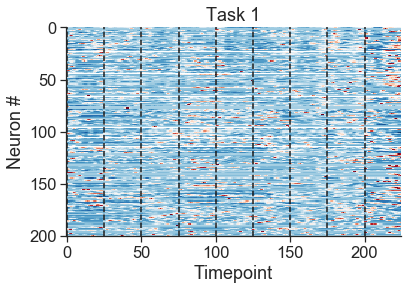

In [44]:
plt.title("Task 1")
aa = np.mean(task_1,axis=0)#np.nanmean(all_big_array[2:],axis=0)
aa /=np.max(aa,axis=1)[:,None]
aa = aa - np.mean(aa,axis=1)[:,None]
#aa /= np.max(aa)
plt.imshow(aa,cmap='RdBu_r',aspect=.7,interpolation="None")
for ii in range(9):
    plt.axvline(x=ii*n_timepoints,linestyle='--',color='k',alpha=1)
seaborn.despine()
plt.xlabel('Timepoint')
plt.ylabel("Neuron #")
task_1.shape

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Neuron #')

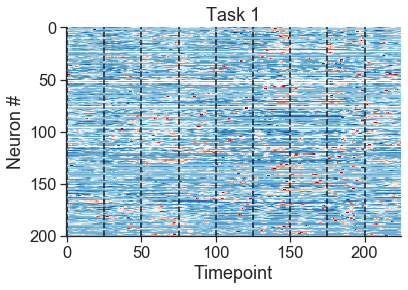

In [41]:
plt.title("Task 1")
aa = np.nanmean(all_big_array[2:],axis=0)
aa /=np.max(aa,axis=1)[:,None]
aa = aa - np.mean(aa,axis=1)[:,None]
#aa /= np.max(aa)
plt.imshow(aa,cmap='RdBu_r',aspect=.7,interpolation="None")
for ii in range(9):
    plt.axvline(x=ii*n_timepoints,linestyle='--',color='k',alpha=1)
seaborn.despine()
plt.xlabel('Timepoint')
plt.ylabel("Neuron #")


Text(0, 0.5, 'Neuron #')

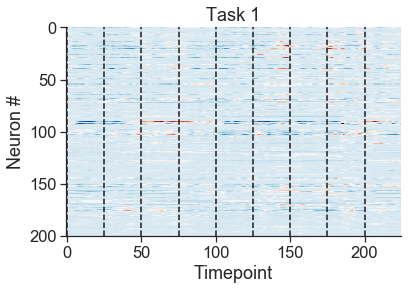

In [47]:
plt.title("Task 1")
aa = np.nanmean(all_big_array[2:],axis=0)
#aa /= np.mean(aa,axis=1)[:,None]
aa = aa - np.mean(aa,axis=1)[:,None]
#aa /= np.max(aa)
plt.imshow(aa,cmap='RdBu_r',aspect=.7,interpolation="None")
for ii in range(9):
    plt.axvline(x=ii*n_timepoints,linestyle='--',color='k',alpha=1)
seaborn.despine()
plt.xlabel('Timepoint')
plt.ylabel("Neuron #")


In [51]:
U,S,Vt = np.linalg.svd(aa)

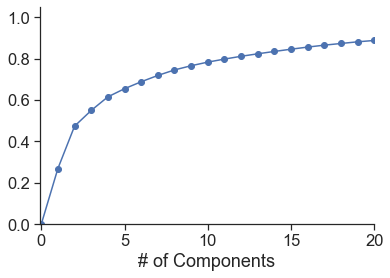

In [64]:
plt.plot(np.concatenate([[0],np.cumsum(S**2)/np.sum(S**2)]),marker='o')
plt.xlim(-.1,20)
plt.ylim(0)
plt.xlabel('# of Components')
seaborn.despine()

In [123]:
conditions =  np.logical_and.reduce([ccs_across<99,
                                    ccs_within>=.3])

NameError: name 'ccs_across' is not defined

In [124]:
neuron_ix =6 #33
print(ccs_within[neuron_ix])
np.corrcoef(all_big_array[0][neuron_ix][:-n_timepoints],
            all_big_array[1][neuron_ix][n_timepoints:])

NameError: name 'ccs_within' is not defined

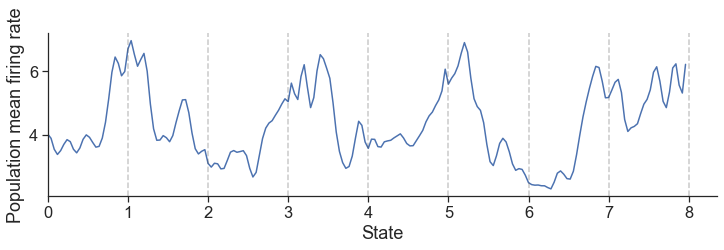

In [125]:
plt.figure(figsize=(12,3))
plt.plot(np.mean(all_big_array[0],axis=0))
for ii in range(9):
    plt.axvline(x=ii*n_timepoints,linestyle='--',color='.3',alpha=.3)
plt.xlim(0)
#plt.ylabel("$\propto$ firing rate")
plt.xticks(np.arange(0,225,25),np.arange(9))
mx = np.nanmax(rate)
plt.ylabel("Population mean firing rate")
plt.xlabel("State")
seaborn.despine()

In [126]:
task_nr = 0
plt.plot(all_big_array[2*task_nr+0][single_units[148]])

IndexError: index 387 is out of bounds for axis 0 with size 313

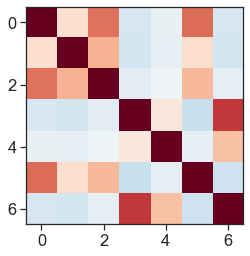

In [127]:
plt.imshow(np.corrcoef(all_big_array[2][grid_cell_list][:,:-n_timepoints]),vmin=-1,vmax=1,cmap='RdBu_r')

In [129]:
np.corrcoef(grid_map_corr.flatten(),np.corrcoef(all_big_array[2][grid_cell_list][:,:-n_timepoints]).flatten())

array([[1.        , 0.71688314],
       [0.71688314, 1.        ]])

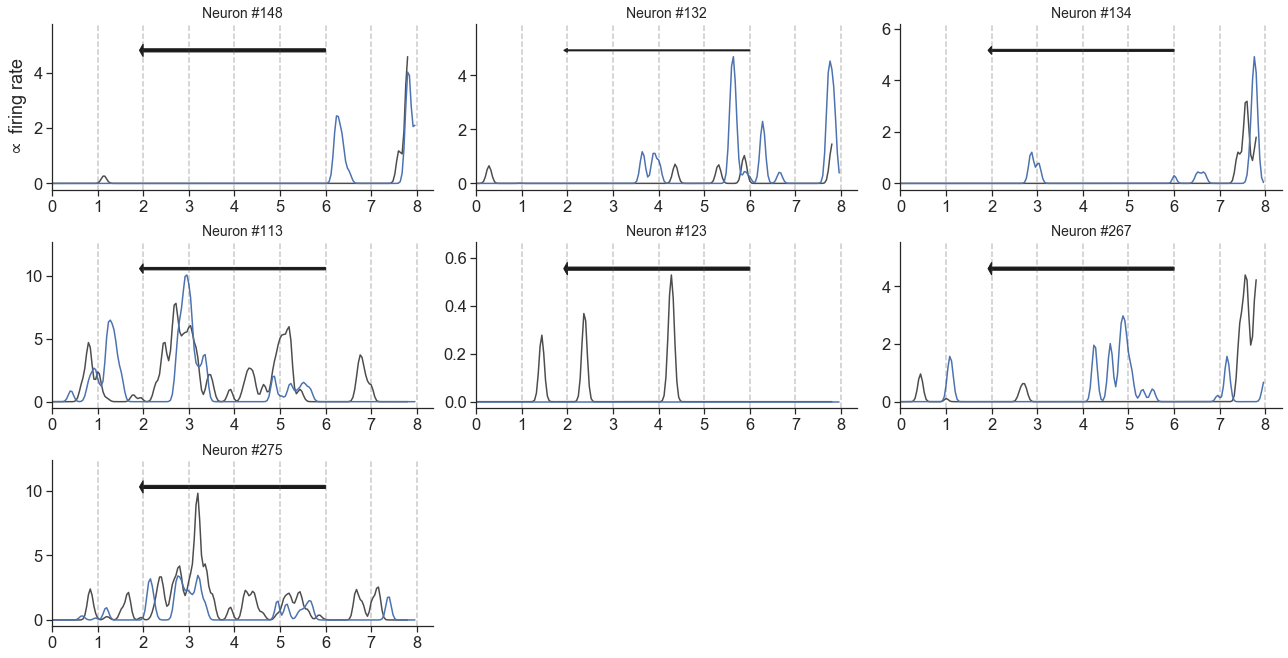

In [131]:
grid_cell_list = [148,132,134,113,123,267,275]
plt.figure(figsize=(18,18))
kk = 0

task_nr = 0
for neuron_ix in grid_cell_list:#np.argsort(np.nansum(all_big_array[0],axis=1))[::-1][:18]:
    #print(neuron_ix,kk,grid_cell_list[kk])
    plt.subplot(6,3,kk+1)
    plt.title("Neuron #{}".format(grid_cell_list[kk]),fontsize=14)

    rate = gaussian_filter1d(all_big_array[2*task_nr+0][neuron_ix],1)
    plt.plot(rate,color='.3')
    plt.plot(gaussian_filter1d(all_big_array[2*task_nr+1][neuron_ix][n_timepoints:],1))

    for ii in range(9):
        plt.axvline(x=ii*n_timepoints,linestyle='--',color='.3',alpha=.3)
    plt.xlim(0)
    if kk==0: plt.ylabel("$\propto$ firing rate")
    plt.xticks(np.arange(0,225,25),np.arange(9))
    mx = np.nanmax(rate)
    plt.gca().arrow(150, plt.gca().get_ylim()[1], -100, 0, width = .025*mx, head_width = mx*.1* 1, 
              head_length = 2 * 1,color='k')

    plt.ylim(np.array(plt.gca().get_ylim())*np.array([1,1.2]))
    kk+= 1
    plt.tight_layout()
seaborn.despine()

In [70]:
conditions = ccs_across<.4

NameError: name 'ccs_across' is not defined

In [594]:
ab1 = all_big_array[0][conditions,:-n_timepoints] - np.mean(all_big_array[0][conditions,:-n_timepoints],axis=1)[:,None]
#ab1 = ab1/np.std(ab1,axis=1)[:,None]
#ab1[~np.isfinite(ab1)] = 0

In [595]:
#np.isfinite(ab1).sum(axis=1)

In [596]:
#ab1 = all_big_array[0][conditions,:-n_timepoints]

In [597]:
np.all(np.isfinite(ab1[:,:-n_timepoints]))

True

In [598]:
U,S,V = np.linalg.svd(ab1)

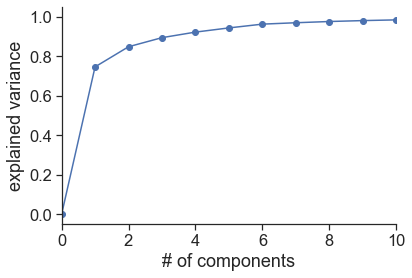

In [599]:
plt.plot([0]+np.cumsum(S**2/np.sum(S**2)).tolist(),marker='o')
plt.xlim(0,10)
plt.ylabel("explained variance")
plt.xlabel("# of components")
seaborn.despine()

In [600]:
from scipy.spatial.distance import pdist, squareform

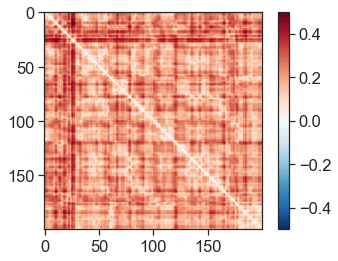

In [601]:
plt.imshow(squareform(pdist(V[:5].T)),interpolation='None',cmap='RdBu_r',vmin=-.5,vmax=.5)
plt.colorbar()

In [691]:
from scipy.interpolate import interp1d


#pos_diff = np.array([np.sum((i-j)**2) for i,j in zip(poke_pos[1:],poke_pos[:-1])])
pos_seq_x = np.array([poke_pos[i,0] for i in dicts[2]['seq']])
pos_seq_y = np.array([poke_pos[i,1] for i in dicts[2]['seq']])


interp_method = 'cubic' #linear, slinear, cubic, quadratic
interper_x = interp1d(np.linspace(0,8,num=9),pos_seq_x,kind=interp_method)
interper_y = interp1d(np.linspace(0,8,num=9),pos_seq_y,kind=interp_method)

seq_pos_new = np.linspace(0,8,num=V[i].shape[0])
x_pos_interp = interper_x(seq_pos_new)
y_pos_interp = interper_y(seq_pos_new)

pos_interp = np.vstack([x_pos_interp,y_pos_interp])
#pos_interp = np.linspace(0,8,num=V[i].shape[0]).reshape(1,-1)

In [692]:
aax = squareform(pdist(pos_interp.T))

In [693]:
#aax = squareform(pdist(y_pos_interp.reshape(-1,1)))

In [694]:
abx = squareform(pdist(all_big_array[1][:,n_timepoints:].T))

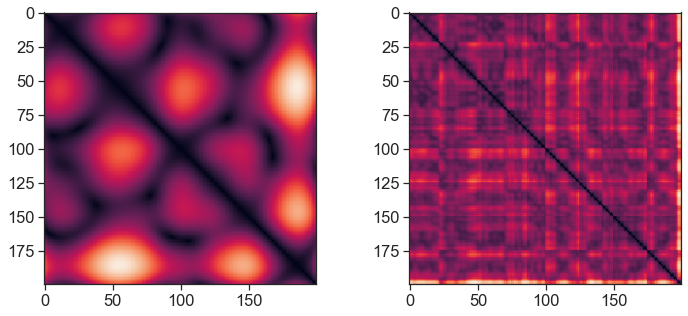

In [695]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(aax,interpolation='None')

plt.subplot(1,2,2)
plt.imshow(abx)

In [689]:
np.corrcoef(aax.flatten(),abx.flatten())

array([[1.        , 0.21536138],
       [0.21536138, 1.        ]])

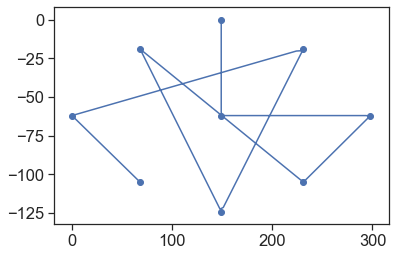

In [607]:
plt.plot(x_pos_interp,y_pos_interp)
plt.scatter(pos_seq_x,pos_seq_y)

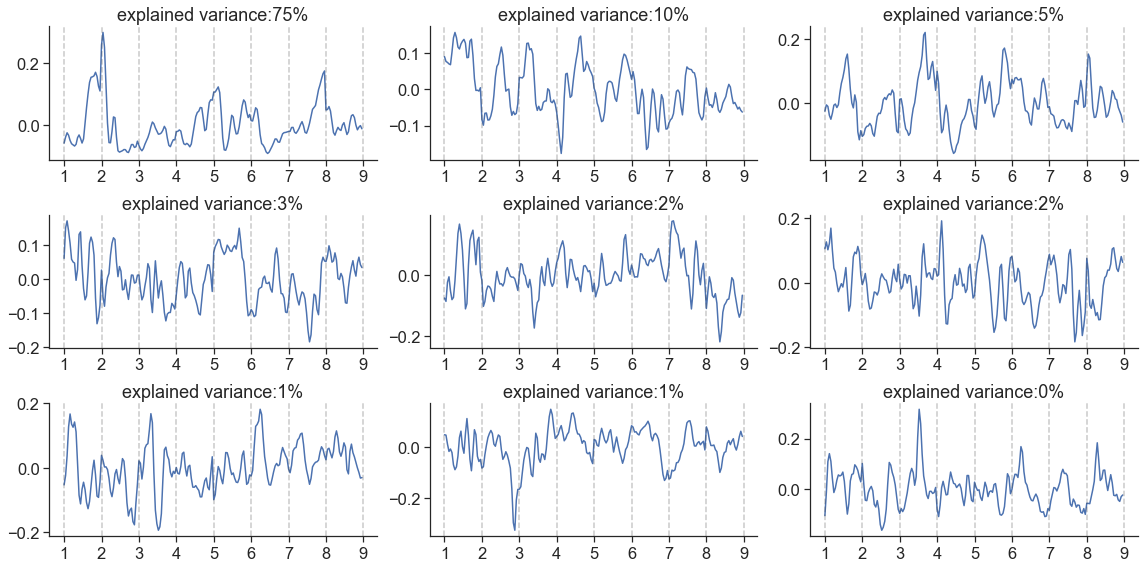

In [608]:
plt.figure(figsize=(16,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title('explained variance:{:.0f}%'.format(100*S[i]**2/np.sum(S**2)))
    plt.plot(V[i])
    for ii in range(9):
        plt.axvline(x=ii*n_timepoints,linestyle='--',color='.3',alpha=.3)
    plt.xticks(np.arange(0,225,25),np.arange(1,10))
    #plt.xlim(0)
#plt.xlabel("State")

plt.tight_layout()
seaborn.despine()

In [491]:
cc_across_dir = []
for neuron_ix in range(all_big_array[0].shape[0]):
    a1,a2 = all_big_array[0][neuron_ix][:-n_timepoints],all_big_array[1][neuron_ix][n_timepoints:]
    #a1 = np.flipud(a1)
    tmp_ = np.corrcoef(a1,a2)[0,1]
    cc_across_dir.append(tmp_)
cc_across_dir = np.array(cc_across_dir)

Text(0.5, 0, 'Correlation activity vectors\nin diff. directions')

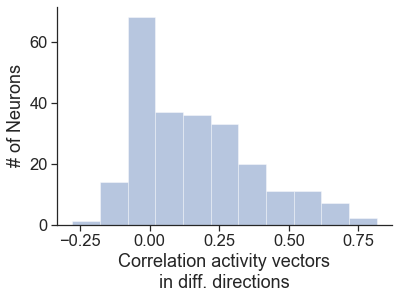

In [492]:
seaborn.distplot(cc_across_dir[np.isfinite(cc_across_dir)],kde=0)
seaborn.despine()
plt.ylabel("# of Neurons")
plt.xlabel("Correlation activity vectors\nin diff. directions")

In [395]:
trial_events[0]

array([175251., 175638.])

In [241]:
1108834/1000/60

18.480566666666668

In [198]:
spkT_ms

array([nan, nan, nan, ..., nan, nan, nan])

In [186]:
trial_events[0][0]

127169.0

In [185]:
np.nanmin(spkT_ms)

30270.700019808144

In [157]:
n_timepoints

60

In [466]:
#poke_dict_t1 ={}
#poke_dict_t2 = {}

dicts1 = [{} for _ in range(4)]
for port_nr in np.unique(df['port'].values):
    
    kk = 0
    for direction in np.unique(df['direction'].values):
        for task_nr in range(2):
            task_nr = str(task_nr)
            v = df.loc[(df['port']==port_nr) &
                       (df['correct']==True) & 
                       (df['port_repeat']==False) & 
                       (df['direction']==direction) &
                       (df['task_nr']==task_nr)]['time'].values
            RT = df.loc[(df['port']==port_nr) &
                       (df['correct']==True) & 
                       (df['port_repeat']==False) & 
                       (df['direction']==direction) &
                       (df['task_nr']==task_nr)]['RT'].values

            dicts1[kk][str(port_nr)] = [[float(v_),float(v_)-float(rt_)] for v_,rt_ in zip(v,RT)]
            dicts1[kk]['task_nr'] = str(task_nr)
            dicts1[kk]['direction'] = str(direction)
            dicts1[kk]['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            dicts1[kk]['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
        
            kk += 1
   

In [467]:
dicts1[0]['0']

[[33564.0, 33017.0],
 [55782.0, 55309.0],
 [79548.0, 79010.0],
 [92848.0, 92353.0],
 [133276.0, 131321.0],
 [192522.0, 191839.0],
 [226763.0, 226143.0],
 [246882.0, 246307.0],
 [703956.0, 701666.0],
 [761875.0, 761358.0],
 [782672.0, 782203.0],
 [816805.0, 816302.0],
 [844238.0, 842460.0],
 [865028.0, 863442.0],
 [924029.0, 922626.0]]

In [468]:
dicts[0]['0']

[[97397.0, 98031.0],
 [117036.0, 117647.0],
 [144837.0, 145292.0],
 [147641.0, 148181.0],
 [209514.0, 210169.0],
 [250713.0, 251242.0],
 [720156.0, 720641.0],
 [733103.0, 733837.0],
 [738675.0, 739253.0],
 [799786.0, 800308.0],
 [848765.0, 849307.0],
 [871515.0, 871979.0],
 [912610.0, 913172.0]]

In [469]:
from scipy.ndimage import gaussian_filter1d

# assess stability

In [470]:
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [471]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [472]:
def get_with_and_across_correlations(all_resps1_g1,all_resps2_g1,all_resps1_g2,all_resps2_g2):
    
    """ Get correlations between neural activity across behaivour on the two different graphs
        as well as across split halves of the same graph
    """

    ccs_within1 = []
    for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
        ccs_within1.append(np.corrcoef(r1,r2)[0,1])

    ccs_within1 = np.array(ccs_within1)
    print(np.nanmean(ccs_within1))

    ccs_within2 = []
    for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
        ccs_within2.append(np.corrcoef(r1,r2)[0,1])
    ccs_within2 = np.array(ccs_within2)

    print(np.nanmean(ccs_within2))


    ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
    ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)


    #
    ccs_across = []
    for r1,r2 in zip(all_resps_g1,all_resps_g2):
        ccs_across.append(np.corrcoef(r1,r2)[0,1])

    ccs_across = np.array(ccs_across)
    print(np.nanmean(ccs_across))
    
    return ccs_within,ccs_across,(ccs_within1,ccs_within2)

In [473]:
ccs_within,ccs_across,_ = get_with_and_across_correlations(all_resps1_g1,all_resps2_g1,all_resps1_g2,all_resps2_g2)

0.7037000646369044
0.6638797364474686
0.5756432030882451


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# make it work

In [141]:
window0 = 0000
window1 = 12000
out1 = get_all_resps(aligner,dicts[0],single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1


out2 = get_all_resps(aligner,dicts[2],single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [149]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=0,order=dicts[0]['seq'])
store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=0,order=dicts[2]['seq'],flip=True)

In [150]:
len(all_resps_g1_single_trial[4][3][0])

12000